Python version 3.4.3 |Anaconda 2.3.0 (x86_64)| (default, Mar  6 2015, 12:07:41) 
[GCC 4.2.1 (Apple Inc. build 5577)]




Hi baby, welcome to SynBioCAD. 	I'm here for you.
Right now, we assume you're working in S. cerevisiae.

What do you want to do today?

	 1 	 add DNA into a characterized locus

	 2 	 edit an existing gene, e.g., delete or replace

	 3 	 build a custom cassette

Your answer: 
1

These are the sites we have:	


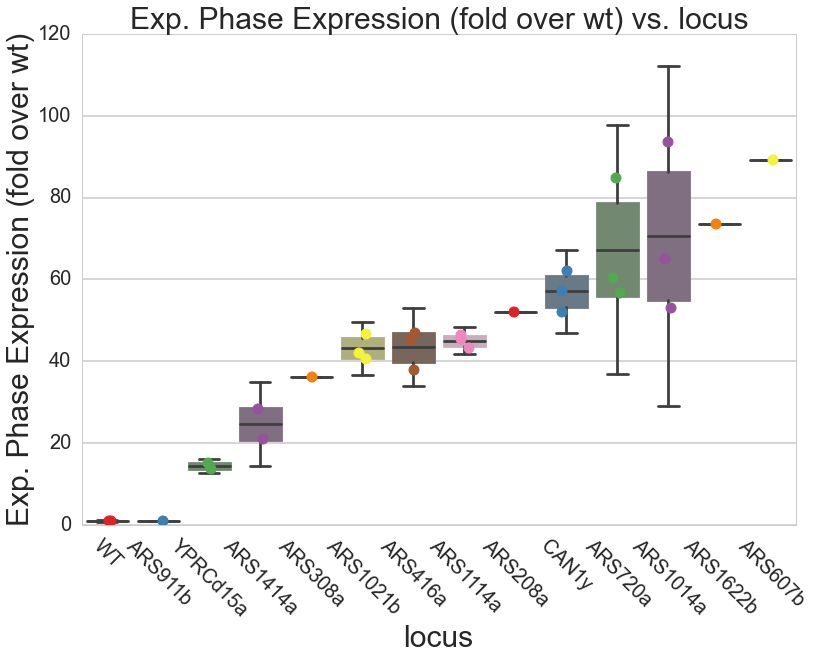

          cutChr           cutSequence
cutName                               
ARS106a   Scer01  ATACGGTCAGGGTAGCGCCC
ARS208a   Scer02  GTCCGCTAAACAAAAGATCT
ARS208b   Scer02  TAGGATACAAGTGTCTGTGC
ARS308a   Scer03  CACTTGTCAAACAGAATATA
LEU2a     Scer03  AAAGGTGAGAGCGCCGGAAC
MATαa     Scer03  GCCCTGGATAGCGAAGCGTG
MATαb     Scer03  AATGATGTCTGGGTTTTGTT
MATαc     Scer03  TGGGAACAAGAGCAAGACGA
RDS1a     Scer03  ATTCAATACGAAATGTGTGC
ARS416a   Scer04  CCTTCAAAGGATTCACCAGA
ARS416b   Scer04  TTAGGGACAGTTAGAGGCGG
ARS416c   Scer04  CAATTCAGGCCAAATCTTGA
ARS416d   Scer04  TAGTGCACTTACCCCACGTT
ARS511b   Scer05  CAGTGTATGCCAGTCAGCCA
URA3a     Scer05  ATTCGCTATTATTCAAGCTT
URA3b     Scer05  CCTTCGTTCTTCCTTCTGCT
CAN1y     Scer05  GATACGTTCTCTATGGAGGA
ARS607b   Scer06  CCAGCGTAAGGTAAATATTA
ARS607c   Scer06  CTATTTTTGCTTTCTGCACA
SAP155b   Scer06  GGTTTTCATACTGGGGCCGC
SAP155c   Scer06  ATGAAAGACAACTATAGGGC
ARS720a   Scer07  CAACAATTGTTACAATAGTA
ARS720b   Scer07  TTTCTTAGCCTAAGCTAGGC
ARS805a   Scer08  TTATTTG

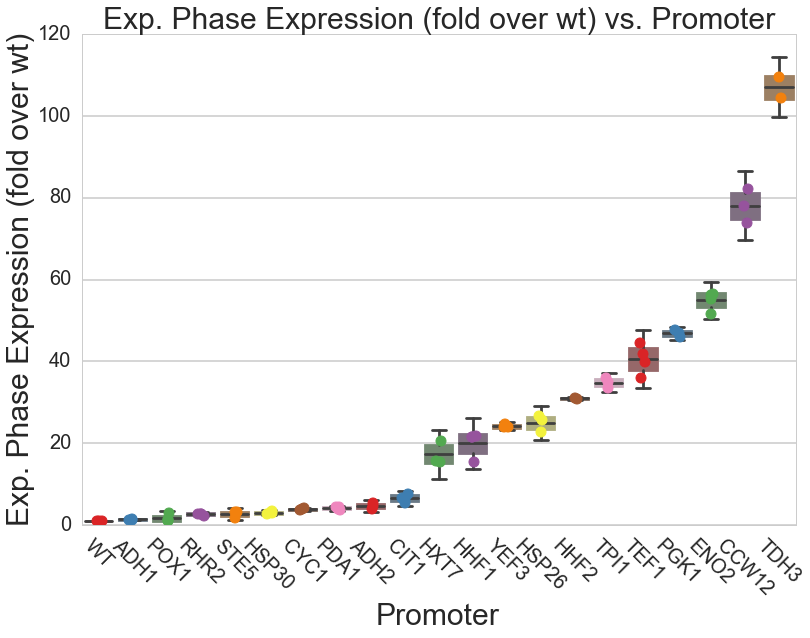

First, which PROMOTER do you want to use, e.g., TDH3
Your answer: TDH3
Which TERMINATOR do you want to use, e.g., ADH1
Your answer: ADH1
What is the name of your gene, e.g., KlGapDH
Your answer: KlGAPDH
What's the sequence
Your answer: ATGGAATGGATTTCACATCTGGAGAACGATGACGATGTGCTGGAAATCGAGGACTACAAGGTGCGCAAGGACGCGCTGCTGATCGCCATTCAAGTAACCCAGAACGCCATTAACAACGGAACTCTTCATAAGGCCTTGGAGGCAGCCTTCGATGCTGTGACTGACAGAATCGTCATATCGCCGCAAGATTACACCGGCGTTATGCTGTTCGGTGCCTCCATGCAGTCTGAGGACGACGGTGACGAGTTCGATGATGAGTCAGATACACATTTCATTCTCAAGCTGGGCCTTCCTACCGCTGCTCAGATCAAACGACTCAAACGACTGGCAGAGGACCCTGATCTGGGTGAGAGGTTCAAGGTGCAGGAAGAGCCTCACCTGATGGACGTGTTTTTCGACATGAACCGCCATTTTATCAACATGGCACCCAACTTCGCGTCCAGACGAATCATCTATATCACAGACGACGATACCCCCACGACGAATGAGGACGATATCAACAAGACACGAGTTCGAATTGAGGATCTAAGCCATCTCAAGGTGAAGGTCGAGCCTCTTTTGATCAACCCTTCGGAAGACAAGACGTTCGACTCCTCCAAATTCTACGCTCTTGTGTTCAACGAAGACACATCTGTGGAGCCGGTTGAGGCGATCGATTTGAAGCAGTTTATCAACAAAAGAAACGTGCTCAATCGATCACTGTTCAATGTCAAAATGGAAATCGGAGAAGGTCTTGTTGTCGGAGTAAGAGGATACCTTCTTTA

In [1]:
'''
SynBioCAD
by Leo d'Espaux and William Zhuang

Current as of 1/11/2016

Recent updates:
*Added figures with current locus and promoter level
'''


# import libraries we're using

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp
import copy
from intermine.webservice import Service
from pandas import *
from pandas import DataFrame, read_csv
import pandas as pd  
import matplotlib.pyplot as plt
import sys
from IPython.display import Image
from IPython.display import display

%matplotlib inline 



# define global variables
HomologyLength = 1000
PrimerMaxTm = 55 # As calculated by statluc, more like 65C by Thermo's Phusion program
PrimerMaxLen = 60
OverhangMaxFrac = 1



def askUser():
    print('Python version ' + sys.version+"\n\n\n\n")
    print("Hi baby, welcome to SynBioCAD. \tI'm here for you.")
    print("Right now, we assume you're working in S. cerevisiae.\n")
    print("What do you want to do today?\n")
    print("\t 1 \t add DNA into a characterized locus\n") 
    print("\t 2 \t edit an existing gene, e.g., delete or replace\n")
    print("\t 3 \t build a custom cassette\n")

   
    Action= input("Your answer: \n")
    if Action == "1":
        editEmpty()
        
    elif Action == "2":
        editExisting()

    elif Action == "3": # This is more for stitching things together not necessarily for CRISPR
        buildCustom()
             
            
            
def editEmpty():    
    
    # I have an excel file where we keep cut site information
    # and load it as a pandas dataframe called cutFrame
    
    cutFrame = pd.read_excel("locusTable.xlsx", index_col="cutName")
    
    print("\nThese are the sites we have:\t")
    
    LocusPic=Image("LocusLevelExp.png")
    display(LocusPic)
 
    print(cutFrame)
         
    print("\nWhich cut site do you want, e.g., ARS208a?\n")
    cutName=input("Your answer: ")

    # cutName is a string that should correspond to one of the variables
    # of the "cutName" column in dataFrame, e.g., ARS208a
    
    # cutFrame has the 20nt sequence of the gRNA saved, which we load
    # It also has some more information we'll get to later
    cutSequence=cutFrame.loc[cutName,'cutSequence']

    # We need to load the chromosome where the cut site is
    location=cutFrame.loc[cutName,'cutChr']+".fasta"
     
    ChromosomeSeq=SeqIO.read(location, "fasta").seq
    
    if ChromosomeSeq.find(cutSequence)==-1:
        ChromosomeSeq=ChromosomeSeq.reverse_complement()
        if ChromosomeSeq.find(cutSequence)==-1:
            print("CAN'T FIND THE CUT SITE IN YOUR SEQUENCE")

    StartIndex=ChromosomeSeq.find(cutSequence)
    EndIndex=StartIndex+34
    
    UpSeq=ChromosomeSeq[StartIndex-HomologyLength:StartIndex]
    DownSeq=ChromosomeSeq[EndIndex:EndIndex+HomologyLength]
        
    UpHomRec = SeqRecord(UpSeq, name=cutName)
    DownHomRec = SeqRecord(DownSeq, name=cutName)
    
    print("\nFound your homology regions. What do you want to do to " + cutName + "?\n")
    print("\t1\t You have an ORF but want help picking promoter and terminator\n")
    print("\t2\t You already have a one-piece cassette and just want to insert it\n\n")
    # Coming later
    # print("\t3\t You want to construct a donor containing two standard cassettes (pointing away from each other\n")

    typeEdit=input("Your answer: ")
    if typeEdit=="1":
    
        PromoterRec, orfRecord, TerminatorRec = buildCassette()
        
        fragments=[UpHomRec, PromoterRec, orfRecord, TerminatorRec, DownHomRec]

    
    elif typeEdit == "2":
        
        orfName=input("What's the name of your custom gene or cassette?")
        orfSeq=Seq(input("What's the sequence?"))
        orfRecord=SeqRecord(orfSeq,name=orfName)
        
        fragments=[UpHomRec, orfRecord, DownHomRec]

    elif typeEdit == "3":
        
        print("Your construct will look like this: ")
        print("up hom-<terminator1-gene1-promoter1<->promoter2-gene2-terminator2>-downhom")
        print("OK, let's build your FIRST cassette")
        PromoterRec1, orfRecord1, TerminatorRec1 = buildCassette()
         
        #now in the construction, these will be in the antisense direction, so let's change their sequences
        rTerminatorRec1=flipRecord(TerminatorRec1)
        rorfRecord1=flipRecord(orfRecord1)
        rPromoterRec1=flipRecord(PromoterRec1)
        
        print("OK, let's build your SECOND cassette")
        PromoterRec2, orfRecord2, TerminatorRec2 = buildCassette()

        fragments=[UpHomRec, rTerminatorRec1, rorfRecord1, rPromoterRec1,PromoterRec2,orfRecord2, TerminatorRec2,DownHomRec]

    stitch(fragments)
    
    
    
def editExisting():
    
    print(" ")
    print("Which locus do you want to edit? Tell me a common name, e.g., \"OAF1\": ")
    print("I'm smart and pretty and I can fetch it for you.")
    
    GeneName= input("Your answer: ")
    
    print("OK let me fetch that for you...")
    print("")

        
    OrigGeneRecord=fetchGene(GeneName)
    #note that this returns a seqrecord
    
    print("")
    print("I found "+OrigGeneRecord.features+":")
    print(OrigGeneRecord.description)


    # We make seqrecords since that's what we carry through later in the program
    UpHomRec = fetchNeighbor(OrigGeneRecord, "upstream", HomologyLength )
    DownHomRec = fetchNeighbor(OrigGeneRecord, "downstream", HomologyLength )
    
    #print("OK I found them.")

    #print(" ")
    #print("UpstreamHomology reghhion is")
    #print(UpHomRec.seq)
    
    #print(" ")
    #print("DownstreamHomology reghhion is")
    #print(DownHomRec.seq)
    
    print(" ")
    print("What do you want to do to this gene?\n")
    print("\t1\t delete the protein coding DNA sequence (CDS)\n")
    print("\t2\t replace the CDS with a cassette--I'll help you pick Promoter and Terminator\n")
    print("\t3\t replace the CDS with another CDS\n\n")
    #print("\t4\t replace the CDS with a custom cassette (soon)")
    #print("\t5\t replace a specified region near your target gene (soon)")
    
    print(" ")
    Action=input("Your answer: ")
                        
    #note that in all the below, we want to have fragments be records
    if Action=="1":
        fragments=[UpHomRec,DownHomRec]
    
    if Action=="2":
        PromoterRec, orfRecord, TerminatorRec = standardCassette()
        fragments=[UpHomRec, PromoterRec, orfRecord, TerminatorRec, DownHomRec] #we need to finish buildcassette to add InsertRec here

    if Action=="3":
        print(" ")
        NewGeneName=input("What's the name of the gene you're inserting?")
        NewGeneSeq=Seq(input("What's the sequence of your new gene?"))
        InsertRec = SeqRecord(NewGeneSeq, name=NewGeneName)
        fragments=[UpHomRec, InsertRec, DownHomRec]

    if Action=="4":
        print("How many pieces (other than homology fragments) are you stitching together.")
        Npieces=input("Your answer: ")
        output = standardCassette()

        fragments=[UpHomRec, DownHomRec] #we need to finish buildcassette to add InsertRec here

        
    stitch(fragments)

    
    
def buildCustom():
    N = int(input("How many pieces in your custom cassette: "))
    fragments = variableCassette(N)[0]
    stitch(fragments)

            
    #------------------------------ FETCH FUNCTIONS -------------------------------------

    
def fetchGene(GeneName):
    
    service = Service("http://yeastmine.yeastgenome.org/yeastmine/service")
    template = service.get_template('Gene_GenomicDNA')

    rows = template.rows(
        E = {"op": "LOOKUP", "value": GeneName, "extra_value": "S. cerevisiae"}
    )
    
    # this service seems to return multiple similar genes but we want the first one only, so count
    # and it returns information about the gene you want
    count=0
    for row in rows:
        
        count=count+1
        if count==1:
            descr= row["description"]
            GeneSeq=Seq(row["sequence.residues"])
            GeneSysName=row["secondaryIdentifier"]
       
    #let's create a record for the oldGene
    GeneRecord = SeqRecord(GeneSeq, id=GeneSysName)
    
    #now let's add some more information to make it useful
    GeneRecord.name=GeneName
    GeneRecord.features=GeneSysName
    GeneRecord.description=descr

    return GeneRecord 
       
    
    
def fetchNeighbor(NeighborRecord, direction, distance):

    # let's load the appropriate chromosome file. The record of the gene we looked up
    # contains in the "features" the systematic name, wherein the second letter
    # corresponds to chromosome number, e.g., 1=A etc
    if NeighborRecord.features[1]=="A":
        ChromosomeRec=SeqIO.read("Scer01.fasta", "fasta")
    if NeighborRecord.features[1]=="B":
        ChromosomeRec=SeqIO.read("Scer02.fasta", "fasta")
    if NeighborRecord.features[1]=="C":
        ChromosomeRec=SeqIO.read("Scer03.fasta", "fasta")
    if NeighborRecord.features[1]=="D":
        ChromosomeRec=SeqIO.read("Scer04.fasta", "fasta")
    if NeighborRecord.features[1]=="E":
        ChromosomeRec=SeqIO.read("Scer05.fasta", "fasta")
    if NeighborRecord.features[1]=="F":
        ChromosomeRec=SeqIO.read("Scer06.fasta", "fasta")
    if NeighborRecord.features[1]=="G":
        ChromosomeRec=SeqIO.read("Scer07.fasta", "fasta")
    if NeighborRecord.features[1]=="H":
        ChromosomeRec=SeqIO.read("Scer08.fasta", "fasta")
    if NeighborRecord.features[1]=="I":
        ChromosomeRec=SeqIO.read("Scer09.fasta", "fasta")
    if NeighborRecord.features[1]=="J":
        ChromosomeRec=SeqIO.read("Scer10.fasta", "fasta")
    if NeighborRecord.features[1]=="K":
        ChromosomeRec=SeqIO.read("Scer11.fasta", "fasta")
    if NeighborRecord.features[1]=="L":
        ChromosomeRec=SeqIO.read("Scer12.fasta", "fasta")
    if NeighborRecord.features[1]=="M":
        ChromosomeRec=SeqIO.read("Scer13.fasta", "fasta")
    if NeighborRecord.features[1]=="N":
        ChromosomeRec=SeqIO.read("Scer14.fasta", "fasta")
    if NeighborRecord.features[1]=="O":
        ChromosomeRec=SeqIO.read("Scer15.fasta", "fasta")
    if NeighborRecord.features[1]=="P":
        ChromosomeRec=SeqIO.read("Scer16.fasta", "fasta") 

    
    
    # let's explicitely name the sequences from the seq record
    NeighborSeq=NeighborRecord.seq
    ChromosomeSeq=ChromosomeRec.seq
    
    # flip the sequence to orient with respect to the old gene
    if ChromosomeSeq.find(NeighborSeq)==-1:
        ChromosomeSeq=ChromosomeSeq.reverse_complement()

    StartIndex=ChromosomeSeq.find(NeighborSeq)
    EndIndex=StartIndex+len(NeighborSeq)
    
    if direction=="upstream":
        DesiredSeq=ChromosomeSeq[StartIndex-distance:StartIndex]
    if direction=="downstream":
        DesiredSeq=ChromosomeSeq[EndIndex:EndIndex+distance]

    
    
    
    NeighborRec = SeqRecord(DesiredSeq, name=NeighborRecord.name)
    
    return NeighborRec

    #print(NeighborRec)

    
    
    
    
    
    
    
    
    
    
    
    #------------------------------------ CONSTRUCTING STUFF --------------------------------------

def getPrimer(currRecord):
    

    mp = 0
    length = 0
    primer = Seq("")

    seq=currRecord.seq
    
    while mp <= PrimerMaxTm and length <= PrimerMaxLen:
        primer = primer + seq[length]
        mp = MeltingTemp.Tm_staluc(primer)
        length += 1

    return primer           
        
def overhangPrimer(currRecord,prevSeq):
    #let's get the template-binding primer first
    primer=getPrimer(currRecord)
    
    
    #OK let's work on the overhang
    maxOhLen=PrimerMaxLen-len(primer)    
    maxFrac=1
    
    #let's decide on a max overhang length
    if round(len(primer)*(OverhangMaxFrac+1)) < 60:
             maxOhLen=round(len(primer)*OverhangMaxFrac)
    
    #the index must be an integer!!!
    maxOhLen=int(maxOhLen)
    ohprimer=prevSeq.seq[-maxOhLen:]+primer #we add the .seq so that it returns a string
    
    return ohprimer      
        

          
def buildCassette():
    
    #first, the promoter
    print("I'm going to build a standard cassette in which promoter is 600nt, terminator 250nt.") 
    print("Here are the promoters we have characterized:")
    PromPic=Image("PromoterLevelExp.png")
    display(PromPic)    
    print("First, which PROMOTER do you want to use, e.g., TDH3")
    
    PromoterName=input("Your answer: ")
    PromoterGeneRec=fetchGene(PromoterName)
    PromoterRec=fetchNeighbor(PromoterGeneRec,"upstream",600)
    PromoterRec.name=PromoterRec.name+"ps"
    
    
    #second, the terminator
    print("Which TERMINATOR do you want to use, e.g., ADH1")
    TerminatorName = input('Your answer: ')
    TerminatorGeneRec=fetchGene(TerminatorName)
    TerminatorRec=fetchNeighbor(TerminatorGeneRec,"downstream",250)
    TerminatorRec.name=TerminatorRec.name+"ts"
    
    #and last, the gene
    print("What is the name of your gene, e.g., KlGapDH")
    orfName = input("Your answer: ")
    
    print("What's the sequence")
    orfSeq=input("Your answer: ")
    
    orfRecord=SeqRecord(Seq(orfSeq), name=orfName)
    
    insertRec=[PromoterRec,orfRecord,TerminatorRec]
    return PromoterRec, orfRecord, TerminatorRec
    
def variableCassette(N, toVary = 0, variants = 0):
    print("")
    print("Let's start building.")
    print("")
    
    # Store both name and sequence in a SeqRecord
    # Append them to a list
    # Return list as fragments to be stitched

    records = []
    for n in range(N):
        name = input("What is the name of sequence " + str(n+1) +":")
        sequence = input("What is the sequence of this fragment:")
        print("")
        Rec = SeqRecord(Seq(sequence), id = str(n+1))
        Rec.name = name
        records.append(Rec)

    variantRecords = []
    variantRecords.append(records)
    # This only happens if there are variants.
    if variants > 0:
        print("Time to make those variants you wanted.")
        for n in range(variants-1):
            name = input("What is the name of variant " + str(n+1) + ":")
            sequence = input("What is the sequence of this variant:")
            Rec = SeqRecord(Seq(sequence), id = str(n+1))
            Rec.name = name
            # Make a copy of the original, switch the fragments and add it to the list. 
            # Deep-copy ensures there are no pointer issues
            tempVariant = copy.deepcopy(records)
            tempVariant[toVary - 1] = Rec
            variantRecords.append(copy.deepcopy(tempVariant))
            print("")

    # Returns a list of lists of the SeqRecords of the fragments
    return variantRecords

def stitch(fragments):
    #this function takes seq records and prints primers
    
    #let's make an empty sequence file
    Nfrags=len(fragments)
    donor=Seq("")
    index=[]
    print("")
    for i in range (0, Nfrags):
        donor=donor+fragments[i]
    
    for i in range (0, Nfrags):
        if i==0:
            print("Lup"+ fragments[i].name + " " + getPrimer(donor))
            print("Rup"+ fragments[i].name + "(" + fragments[i+1].name + ") " + overhangPrimer(fragments[i].reverse_complement(),fragments[i+1].reverse_complement()))
        elif i==Nfrags-1:
            print("Ldown"+ fragments[i].name + "(" + fragments[i-1].name + ") " + overhangPrimer(fragments[i],fragments[i-1]))
            print("Rdown"+ fragments[i].name + " " + getPrimer(donor.reverse_complement()))
        else:
            print("L"+ fragments[i].name + "(" + fragments[i-1].name + ") " + overhangPrimer(fragments[i],fragments[i-1]))
            print("R"+ fragments[i].name + "(" + fragments[i+1].name + ") " + overhangPrimer(fragments[i].reverse_complement(),fragments[i+1].reverse_complement()))

    print("")
    print("The sequence of your donor DNA--and final chromosomal sequence--is below.")
    print("Refer to the following link for more help.")
    print("https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing")



    print("")
    print(len(donor.seq))
    print("")

    print(donor.seq)

    print("")
    print("You might want to copy this entire prompt and save it for your records.")
    
        
def flipRecord(origRecord):
    origRecord.seq=origRecord.seq.reverse_complement()
    origRecord.name="r"+origRecord.name
    return origRecord
    
def pickCut(Sequence):
    from prettytable import from_csv

    print("Which of these characterized loci is going to get lucky: ")

    fp = open("cutsites.csv", "r")
    pt = from_csv(fp)
    fp.close()

    print(pt)

    cutsiteNum = int(input("Choose your cutsite (Leftmost number):"))

    print("")
    print("You've chosen: ")
    print(pt.get_string(start = cutsiteNum-1, end = cutsiteNum))

    counter = 0
    for row in pt:
        counter += 1
        if counter == cutsiteNum:
            row.border = False
            row.header = False
            cutsite = row.get_string(fields=["sequence"]).strip()
            cutName = row.get_string(fields=["name"]).strip()
            chromosome = int(row.get_string(fields=["chromosome"]).strip())
    if chromosome >= 10:
        filename = "Scer" + str(chromosome) + ".fasta" 
    else:
        filename = "Scer0" + str(chromosome) + ".fasta"

    ChromosomeRec=SeqIO.read(filename, "fasta")
    ChromosomeSeq = ChromosomeRec.seq

    if ChromosomeSeq.find(cutsite) == -1:
        ChromosomeSeq = ChromosomeSeq.reverse_complement()

    startInd = ChromosomeSeq.find(cutsite)

    UpHomology = SeqRecord(ChromosomeSeq[startInd - 1000:startInd])
    DownHomology = SeqRecord(ChromosomeSeq[startInd + 30:startInd + 1030])
    return UpHomology, DownHomology



askUser()

